In [18]:
import pandas as pd
import sys
sys.path.append('..')  # Adjust the path based on your project structure
import json
import re
import ast
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay,  average_precision_score
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
# from miga.const import ID2LABELS_SMG_SHORT as ID2LABELS
from mac2024.const import ID2LABELS as ID2LABELS

import datetime

In [19]:
from pathlib import Path
def load_and_parse_txt(path_or_list, feature_names, file_names):
    # Read the text file into a list of lines
    if isinstance(path_or_list, list):
        
        df_list = []
        logit_columns_list = []
        pred_columns_list = []
        gt_columns_list = []
        for p in path_or_list:
            df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(p, feature_names, file_names)
            df_list.append(df)
            logit_columns_list.append(logit_columns)
            pred_columns_list.append(pred_columns)
            gt_columns_list.append(gt_columns)
        return pd.concat(df_list), logit_columns_list, pred_columns_list, gt_columns_list
    elif isinstance(path_or_list, str):
        path = path_or_list

    with open(path, 'r') as file:
        lines = file.readlines()
    


    # Extract relevant information from each line
    data = []
    indecies = []
    TH = 0.4
    for line in lines[1:]:

        
        # Use regex to find index, predictions, and targets
        # match = re.match(r'(\d+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        # match = re.match(r'(\d+\-[^ ]+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        match = re.match(r'(.*?)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        if match:
    

            # index = int(match.group(1))
            index = match.group(1)
            
            # Extract model predictions and convert to list using ast
            logits_str = match.group(2)
            logits = list(ast.literal_eval(logits_str))
            
            predictions = ((np.array(logits)>TH).astype(int)).tolist()


            # Extract targets and convert to list using ast
            targets_str = f'[{match.group(3)}]'
            targets = list(np.array(ast.literal_eval(targets_str)))

            
            row_data = logits + predictions + targets 
            row_data = np.array(row_data)
            data.append(row_data)
            # indecies.append(int(index))
            indecies.append(index)

    # Create column names
    logit_columns = [f"logit-{name}" for name in feature_names]
    pred_columns = [f"pred-{name}" for name in feature_names]
    gt_columns = [f"gt-{name}" for name in feature_names]
    columns = logit_columns + pred_columns + gt_columns 

    # Create Pandas DataFrame
    df = pd.DataFrame(data, columns=columns, index=indecies)
    df[pred_columns+gt_columns] = df[pred_columns+gt_columns].astype(int)
    # print(df.iloc[0])
    # print(df.tail(1))
    df['filenames'] = file_names
    df['log_name'] = osp.basename(path)

    return df, logit_columns, pred_columns, gt_columns
    # return data, columns
# df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,file_names)

In [20]:
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/MPIIGroupInteraction'
# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
# run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual_multi'

# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8'
# run_name = 'eval_on_original'
# 'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8\eval after downsampleing'
experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments'
run_name = 'mac_multi'

In [21]:
# path_to_weights = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_001/dataset/weights.json'
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_5vid_clean'
# run_name = 'videomae_vit_base_patch16_224_tubemasking_ratio_0.9_kinetic_400'
path_to_weights = osp.join(experiment_folder,run_name,'dataset','weights.json')
with open(path_to_weights, 'r') as json_file:
    positive_weights_dict = json.load(json_file)

        
feature_names = [entry['class'] for entry in positive_weights_dict['data']]

In [136]:
# path_to_log = glob(osp.join(experiment_folder,run_name,'outputs_eval','*.txt'))
# # path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')

# path_to_log = glob(osp.join(experiment_folder,run_name,'','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval after downsampleing','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'validation_best_after_100_epochs','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'delete_later','*.txt'))
path_to_log = glob(osp.join(experiment_folder,run_name,'eval_28','*.txt'))


# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')



# Get names of file names from the csv file
df_csv = pd.read_csv(path_to_dataset)
file_names = df_csv['filenames'].tolist()
metadata = df_csv['metadata'].tolist()
df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,file_names)
# df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,'')
# data, columns = load_and_parse_txt(path_to_log, feature_names)
df = df.drop(columns='log_name').groupby('filenames').mean()
logit_columns=logit_columns[0]
pred_columns=pred_columns[0]
gt_columns=gt_columns[0]

C:\Users\user\AppData\Local\Temp\ipykernel_14960\802085671.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['filenames'] = file_names
C:\Users\user\AppData\Local\Temp\ipykernel_14960\802085671.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['log_name'] = osp.basename(path)


In [27]:


# df['side'] = df.index.str.split('/').str[-2]
# df['camera_name'] = df.index.str.split('/').str[-3]
# df['view'] = df['camera_name'].apply(lambda x: 'top' if x == 'Cam3' else 'front' if x == 'Cam4' else None)

In [28]:
# # print(sum(df['gt-lgcr']))
# # print(len(df))
# # th = 0.5
# # print(sum(df['logit-lgcr']>th))
# df.loc[(df['gt-lgcr']==0) & (df['logit-lgcr']>th)][['gt-lgcr','logit-lgcr']]

In [29]:
# df['time_second'] = df.index.str.split('/').str[-1].str.split('.').str[0].astype(int) * 2
# df['time_minutes'] = df['time_second'].apply(lambda x: str(datetime.timedelta(seconds=x)))


In [30]:
# fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/left/0092.mp4'
# partial_fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/'
# time_range = [57, 70]
# columns_to_check = ['gt-lgcr','logit-lgcr']
# df.loc[(df.index.str.contains(partial_fname))&(df['time_second']>time_range[0])&(df['time_second']<=time_range[1])][columns_to_check]

In [31]:
# df.to_csv(osp.join(experiment_folder, run_name, 'raw_test_results.csv'))

In [138]:
# Summarize metrics using classification report
def generate_report(df_in, th=None):
    
    def get_scores(metric_name, metric_function):

        average_metric = dict()
        for class_name in y_true_df.columns:
            
            y_true = gt[class_name].values
            y_pred = logits[class_name.replace('gt','logit')].values
            ap = metric_function(y_true, y_pred)
            # average_metric[int(class_name.replace('gt-',''))]= ap
            average_metric[class_name.replace('gt-','')]= ap
        
        avg_types = ['micro', 'samples', 'weighted', 'macro']
        metric_df = dict()
        for avg_type in avg_types:
            metric_df[avg_type+' avg'] = metric_function(gt, logits,average=avg_type)
        average_metric.update(metric_df)
        average_metric_df = pd.DataFrame(average_metric.values(), index=average_metric.keys(), columns=[metric_name])
        return average_metric_df
    
    df = df_in.copy()
    if th is not None:
        if isinstance(th,float):
            # th_dict = {k:th for k in range(len(feature_names))} 
            th_dict = {k:th for k in feature_names}
        elif isinstance(th, dict):
            th_dict = th
        
        for k, v in th_dict.items():
            df['pred-'+str(k)] = df['logit-'+str(k)] >= v
    else:
        th_dict = {k:np.nan for k in range(len(feature_names))}
        
    gt = df[gt_columns]
    predictions = df[pred_columns]
    logits = df[logit_columns]
    

    classification_rep = classification_report(gt, predictions, output_dict=True, target_names=feature_names)
    df_report = pd.DataFrame.from_dict(classification_rep).transpose()
    def id_to_labels(x):
        try:
            x = int(x)
        except:
            return x
        return ID2LABELS[x+1]
    df_ap = get_scores(metric_name='AP', metric_function=average_precision_score)
    df_auc = get_scores(metric_name='AUC', metric_function=roc_auc_score)
    df_th = pd.DataFrame(th_dict.values(), index=th_dict.keys(), columns=['threshold'])
    df_report = df_report.join(df_ap).join(df_auc).join(df_th)
    
    
    
    
    df_report['labels'] = df_report.reset_index()['index'].apply(id_to_labels)
    

    # add auc
    # Calculate ROC-AUC for each label
    roc_auc_scores = {}
    roc_metrics = {}
    
    feature_names_str = [str(a) for a in feature_names]
    for column in feature_names_str:
        
        true_label = gt['gt-'+column]
        pred_prob = logits['logit-'+column]
        roc_auc = roc_auc_score(true_label, pred_prob)
        # roc_auc_scores[int(column)] = roc_auc
        roc_auc_scores[column] = roc_auc
        fpr, tpr, thresholds = roc_curve(true_label, pred_prob)
        roc_metrics[column] = dict(
            fpr=fpr,
            tpr=tpr,
            thresholds=thresholds,
            auc = roc_auc
        )
    
    
    return df_report, logits, gt, roc_metrics

# df_report, logits, gt = generate_report(df, th=optimal_th_dict)
df_report, logits, gt, roc_metrics = generate_report(df)

# df_report['view'] = 'center'

# df_top = df[df['view'] == 'top']
# df_report_top, logits_top, gt_top = generate_report(df_top)
# df_report_top['view'] = 'top'
# 
# df_front = df[df['view'] == 'front']
# df_report_front, logits_front, gt_front = generate_report(df_front)
# df_report_front['view'] = 'front'



C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [42]:
df_report

,precision,recall,f1-score,support,AP,AUC,threshold,labels
shaking body,0.239468,0.705882,0.357616,153.0,0.369167,0.941289,NaN,NaN
sitting straightly,0.149123,0.459459,0.225166,74.0,0.192497,0.937523,NaN,NaN
shrugging,0.000000,0.000000,0.000000,9.0,0.008394,0.900006,NaN,NaN
turning around,0.000000,0.000000,0.000000,3.0,0.002260,0.743507,NaN,NaN
rising up,0.321429,0.592105,0.416667,76.0,0.431628,0.952333,NaN,NaN
bowing head,0.000000,0.000000,0.000000,168.0,0.057268,0.674425,NaN,NaN
head up,0.000000,0.000000,0.000000,121.0,0.078426,0.703291,NaN,NaN
tilting head,0.000000,0.000000,0.000000,228.0,0.099432,0.710687,NaN,NaN
turning head,0.264865,0.102083,0.147368,480.0,0.217189,0.747240,NaN,NaN
nodding,0.342709,0.722309,0.464859,641.0,0.356036,0.851163,NaN,NaN


In [155]:
# df_concat = pd.concat([df_report,df_report_top,df_report_front], axis=0)
# df_concat_f1 = df_concat[['f1-score','view']].pivot(columns=['view'])
# df_concat_f1['support'] = df_report['support']

In [156]:
# df_concat_f1.sort_values(by=['support'])

In [43]:
feature_names_str = [str(a) for a in feature_names]

In [45]:
# Calculate ROC-AUC for each label
roc_auc_scores = {}
roc_metrics = {}

for column in feature_names_str:
    
    true_label = gt['gt-'+column]
    pred_prob = logits['logit-'+column]
    roc_auc = roc_auc_score(true_label, pred_prob)
    # roc_auc_scores[int(column)] = roc_auc
    roc_auc_scores[column] = roc_auc
    fpr, tpr, thresholds = roc_curve(true_label, pred_prob)
    roc_metrics[column] = dict(
        fpr=fpr,
        tpr=tpr,
        thresholds=thresholds,
        auc = roc_auc
    )


# Display ROC-AUC scores for each label
for label, roc_auc in roc_auc_scores.items():
    print(f'ROC-AUC for {label}: {roc_auc}')

ROC-AUC for shaking body: 0.9412889519265586
ROC-AUC for sitting straightly: 0.9375232907072529
ROC-AUC for shrugging: 0.9000059769290538
ROC-AUC for turning around: 0.7435070750492567
ROC-AUC for rising up: 0.9523330786130482
ROC-AUC for bowing head: 0.6744246471198299
ROC-AUC for head up: 0.7032914187201803
ROC-AUC for tilting head: 0.7106867579549845
ROC-AUC for turning head: 0.7472399709492101
ROC-AUC for nodding: 0.85116294843907
ROC-AUC for shaking head: 0.8543554869353072
ROC-AUC for scratching arms: 0.9444476160029229
ROC-AUC for playing objects: 0.8136205114957376
ROC-AUC for putting hands together: 0.7873223909377605
ROC-AUC for rubbing hands: 0.9084071364394815
ROC-AUC for pointing oneself: 0.9307000373881106
ROC-AUC for clenching fist: 0.8307194381261781
ROC-AUC for stretching arms: 0.9259473197781886
ROC-AUC for retracting arms: 0.8889653407398395
ROC-AUC for waving: 0.9415521451829152
ROC-AUC for spreading hands: 0.9295376557029585
ROC-AUC for hands touching fingers: 0.86

In [46]:
roc_auc_scores

{'shaking body': 0.9412889519265586,
 'sitting straightly': 0.9375232907072529,
 'shrugging': 0.9000059769290538,
 'turning around': 0.7435070750492567,
 'rising up': 0.9523330786130482,
 'bowing head': 0.6744246471198299,
 'head up': 0.7032914187201803,
 'tilting head': 0.7106867579549845,
 'turning head': 0.7472399709492101,
 'nodding': 0.85116294843907,
 'shaking head': 0.8543554869353072,
 'scratching arms': 0.9444476160029229,
 'playing objects': 0.8136205114957376,
 'putting hands together': 0.7873223909377605,
 'rubbing hands': 0.9084071364394815,
 'pointing oneself': 0.9307000373881106,
 'clenching fist': 0.8307194381261781,
 'stretching arms': 0.9259473197781886,
 'retracting arms': 0.8889653407398395,
 'waving': 0.9415521451829152,
 'spreading hands': 0.9295376557029585,
 'hands touching fingers': 0.8622739042378627,
 'other finger movements': 0.7908333333333333,
 'illustrative gestures': 0.9167494793398472,
 'shaking legs': 0.8482829751618958,
 'curling legs': 0.907412864463

In [47]:
roc_values =  list(roc_auc_scores.values()) + [np.nan]* (len(df_report)-len(roc_auc_scores.values()))
df_report['auc'] = roc_values
df_report

,precision,recall,f1-score,support,AP,AUC,threshold,labels,auc
shaking body,0.239468,0.705882,0.357616,153.0,0.369167,0.941289,NaN,NaN,0.941289
sitting straightly,0.149123,0.459459,0.225166,74.0,0.192497,0.937523,NaN,NaN,0.937523
shrugging,0.000000,0.000000,0.000000,9.0,0.008394,0.900006,NaN,NaN,0.900006
turning around,0.000000,0.000000,0.000000,3.0,0.002260,0.743507,NaN,NaN,0.743507
rising up,0.321429,0.592105,0.416667,76.0,0.431628,0.952333,NaN,NaN,0.952333
bowing head,0.000000,0.000000,0.000000,168.0,0.057268,0.674425,NaN,NaN,0.674425
head up,0.000000,0.000000,0.000000,121.0,0.078426,0.703291,NaN,NaN,0.703291
tilting head,0.000000,0.000000,0.000000,228.0,0.099432,0.710687,NaN,NaN,0.710687
turning head,0.264865,0.102083,0.147368,480.0,0.217189,0.747240,NaN,NaN,0.747240
nodding,0.342709,0.722309,0.464859,641.0,0.356036,0.851163,NaN,NaN,0.851163


In [48]:
df_ruc = pd.DataFrame.from_dict(roc_metrics).transpose()
optimal_th_inds = [np.argmax(a) for a in (df_ruc['tpr'].values - df_ruc['fpr'].values)]
th = df_ruc['thresholds'].values
optimal_th = [a[t] for t, a in zip(optimal_th_inds, th)]
optimal_th_dict = {n:opt for n,opt in zip(feature_names, optimal_th)}
optimal_th_dict


{'shaking body': 0.0965576171875,
 'sitting straightly': 0.07275390625,
 'shrugging': 0.0182952880859375,
 'turning around': 0.004627227783203125,
 'rising up': 0.2099609375,
 'bowing head': 0.090576171875,
 'head up': 0.1221923828125,
 'tilting head': 0.1759033203125,
 'turning head': 0.274169921875,
 'nodding': 0.21630859375,
 'shaking head': 0.178955078125,
 'scratching arms': 0.1549072265625,
 'playing objects': 0.0703125,
 'putting hands together': 0.040679931640625,
 'rubbing hands': 0.0726318359375,
 'pointing oneself': 0.12261962890625,
 'clenching fist': 0.060638427734375,
 'stretching arms': 0.254150390625,
 'retracting arms': 0.06781005859375,
 'waving': 0.1953125,
 'spreading hands': 0.1971435546875,
 'hands touching fingers': 0.136474609375,
 'other finger movements': 0.1246337890625,
 'illustrative gestures': 0.2130126953125,
 'shaking legs': 0.12548828125,
 'curling legs': 0.1390380859375,
 'spread legs': 0.06756591796875,
 'closing legs': 0.09368896484375,
 'crossing le

In [49]:
optimal_th

[0.0965576171875,
 0.07275390625,
 0.0182952880859375,
 0.004627227783203125,
 0.2099609375,
 0.090576171875,
 0.1221923828125,
 0.1759033203125,
 0.274169921875,
 0.21630859375,
 0.178955078125,
 0.1549072265625,
 0.0703125,
 0.040679931640625,
 0.0726318359375,
 0.12261962890625,
 0.060638427734375,
 0.254150390625,
 0.06781005859375,
 0.1953125,
 0.1971435546875,
 0.136474609375,
 0.1246337890625,
 0.2130126953125,
 0.12548828125,
 0.1390380859375,
 0.06756591796875,
 0.09368896484375,
 0.062225341796875,
 0.118408203125,
 0.1798095703125,
 0.18994140625,
 0.06829833984375,
 0.0792236328125,
 0.07696533203125,
 0.10650634765625,
 0.061981201171875,
 0.10821533203125,
 0.109130859375,
 0.152587890625,
 0.0831298828125,
 0.07861328125,
 0.273681640625,
 0.0794677734375,
 0.199951171875,
 0.011199951171875,
 0.0994873046875,
 0.146240234375,
 0.283447265625,
 0.2427978515625,
 0.11163330078125,
 0.0323486328125,
 0.1663818359375,
 0.25830078125,
 0.2406005859375,
 0.2305908203125]

In [51]:
optimal_preds = df.copy()
for column in feature_names_str:
    pred_prob = logits['logit-'+column]
    # pred = pred_prob>optimal_th_dict[int(column)]
    pred = pred_prob>optimal_th_dict[column]
    optimal_preds['pred-'+column] = pred.astype(int)
df_optimal_preds = pd.DataFrame.from_dict(optimal_preds)


In [52]:
optimal_th_dict

{'shaking body': 0.0965576171875,
 'sitting straightly': 0.07275390625,
 'shrugging': 0.0182952880859375,
 'turning around': 0.004627227783203125,
 'rising up': 0.2099609375,
 'bowing head': 0.090576171875,
 'head up': 0.1221923828125,
 'tilting head': 0.1759033203125,
 'turning head': 0.274169921875,
 'nodding': 0.21630859375,
 'shaking head': 0.178955078125,
 'scratching arms': 0.1549072265625,
 'playing objects': 0.0703125,
 'putting hands together': 0.040679931640625,
 'rubbing hands': 0.0726318359375,
 'pointing oneself': 0.12261962890625,
 'clenching fist': 0.060638427734375,
 'stretching arms': 0.254150390625,
 'retracting arms': 0.06781005859375,
 'waving': 0.1953125,
 'spreading hands': 0.1971435546875,
 'hands touching fingers': 0.136474609375,
 'other finger movements': 0.1246337890625,
 'illustrative gestures': 0.2130126953125,
 'shaking legs': 0.12548828125,
 'curling legs': 0.1390380859375,
 'spread legs': 0.06756591796875,
 'closing legs': 0.09368896484375,
 'crossing le

In [53]:
df_optimal_preds

,logit-shaking body,logit-sitting straightly,logit-shrugging,logit-turning around,logit-rising up,logit-bowing head,logit-head up,logit-tilting head,logit-turning head,logit-nodding,...,gt-touching legs,gt-scratching legs,gt-scratching feet,gt-body,gt-head,gt-hands,gt-legs,side,camera_name,view
filenames,,,,,,,,,,,,,,,,,,,,,
0003_01_0005.mp4,0.011421,0.011688,0.002935,0.000395,0.003338,0.097046,0.126465,0.219482,0.384277,0.498291,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
0003_01_0006.mp4,0.015602,0.026306,0.010902,0.001008,0.005844,0.216675,0.189697,0.216187,0.402588,0.350098,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
0003_01_0008.mp4,0.013588,0.014786,0.004200,0.000432,0.003456,0.117554,0.140747,0.237549,0.412354,0.492920,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
0003_01_0015.mp4,0.094482,0.101929,0.028763,0.002855,0.025620,0.240234,0.182251,0.252686,0.378418,0.242920,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
0003_01_0021.mp4,0.004330,0.006123,0.002068,0.000315,0.001748,0.092346,0.124512,0.188477,0.366943,0.526367,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0193_05_0006.mp4,0.010948,0.013741,0.006565,0.003796,0.009018,0.074219,0.067444,0.122925,0.124329,0.070068,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,None
0193_05_0011.mp4,0.023911,0.025375,0.009232,0.005619,0.014618,0.072876,0.063110,0.133545,0.123230,0.056030,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,None
0193_05_0013.mp4,0.008347,0.010246,0.004433,0.004101,0.008881,0.057373,0.043701,0.082275,0.074890,0.030441,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,None


In [57]:
df_report_optimal, logits, gt, roc_metrics = generate_report(df, th=optimal_th_dict)
df_report_optimal

,precision,recall,f1-score,support,AP,AUC,threshold,labels
shaking body,0.124892,0.947712,0.220700,153.0,0.369167,0.941289,0.096558,NaN
sitting straightly,0.053818,1.000000,0.102139,74.0,0.192497,0.937523,0.072754,NaN
shrugging,0.008123,1.000000,0.016115,9.0,0.008394,0.900006,0.018295,NaN
turning around,0.001407,1.000000,0.002810,3.0,0.002260,0.743507,0.004627,NaN
rising up,0.140426,0.868421,0.241758,76.0,0.431628,0.952333,0.209961,NaN
bowing head,0.046739,0.797619,0.088303,168.0,0.057268,0.674425,0.090576,NaN
head up,0.050238,0.611570,0.092848,121.0,0.078426,0.703291,0.122192,NaN
tilting head,0.094158,0.600877,0.162805,228.0,0.099432,0.710687,0.175903,NaN
turning head,0.181432,0.712500,0.289218,480.0,0.217189,0.747240,0.274170,NaN
nodding,0.286009,0.864275,0.429791,641.0,0.356036,0.851163,0.216309,NaN


In [58]:
# classification_rep = classification_report(gt, df_optimal_preds, output_dict=True, target_names=feature_names)
# df_report = pd.DataFrame.from_dict(classification_rep).transpose()
# # index_mapping = {str(idx): feature_name for idx, feature_name in enumerate(FEATURE_NAMES)}
# # df_report.rename(index=index_mapping, inplace=True)
# df_report.sort_values(by='support')
# df_report = df_report.rename(index={a:f'{a:02}-{ID2LABELS[int(a)+1]}' for a in df_report.index if isinstance(a,int)})
# df_report

In [61]:
# from mean_average_precision import MetricBuilder
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import precision_recall_curve, auc
# 
# y_true_df = df[gt_columns]
# y_pred_df = df[logit_columns]
# 
# # Calculate the average precision for each class
# average_precisions = []
# for class_name in y_true_df.columns:
#     
#     y_true = y_true_df[class_name].values
#     y_pred = y_pred_df[class_name.replace('gt','logit')].values
#     ap = average_precision_score(y_true, y_pred)
#     average_precisions.append(ap)
# 
# # Calculate the mean average precision
# mean_average_precision = np.mean(average_precisions)
# print("Mean Average Precision (MAP):", mean_average_precision)
# 
# 
# # Flatten the arrays to treat them as one long list of true and predicted labels
# y_true_flat = y_true_df.values.ravel()
# y_pred_flat = y_pred_df.values.ravel()
# 
# # Calculate precision and recall for micro-average
# precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)
# 
# # Calculate the area under the precision-recall curve
# micro_avg_precision = auc(recall, precision)
# print("Micro Average Precision (MAP):", micro_avg_precision)

In [59]:
# from sklearn.metrics import average_precision_score
# y_true_df = df[gt_columns]
# y_pred_df = df[logit_columns]
# average_precisions = dict()
# for class_name in y_true_df.columns:
#     
#     y_true = y_true_df[class_name].values
#     y_pred = y_pred_df[class_name.replace('gt','logit')].values
#     ap = average_precision_score(y_true, y_pred)
#     # average_precisions[int(class_name.replace('gt-',''))]= ap
#     average_precisions[class_name.replace('gt-','')]= ap
# 
# avg_types = ['micro', 'samples', 'weighted', 'macro']
# ap_df = dict()
# for avg_type in avg_types:
#     ap_df[avg_type+' avg'] = average_precision_score(y_true_df, y_pred_df,average=avg_type)
# average_precisions.update(ap_df)
# pd.DataFrame(average_precisions.values(), index=average_precisions.keys())

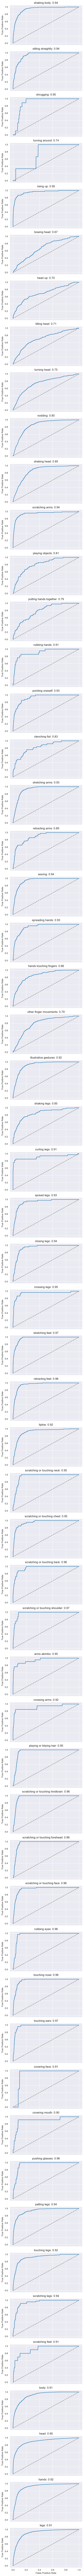

In [63]:
# Plot ROC curves and display additional information
# fig, axes = plt.subplots(nrows=1, ncols=len(roc_metrics), figsize=(15, 5))
num_lables = len(roc_metrics)
fig, axes = plt.subplots(nrows=num_lables, ncols=1, figsize=(5, 150))

for i, (label, metrics) in enumerate(roc_metrics.items()):
    tpr = metrics['tpr']
    fpr = metrics['fpr']
    auc = metrics['auc']
    auc_value = metrics['auc']

    # Plot ROC curve
    axes[i].plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

    # Add title, AUC value, and additional information

    # axes[i].set_title(label)
    
    # axes[i].set_title(f'{ID2LABELS[int(label)+1]}: {auc_value:.2f}')
    axes[i].set_title(f'{label}: {auc_value:.2f}')
    # axes[i].set_title(f'{label}: {auc_value:.2f}')
    # axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    # if i==0:
    if i == num_lables-1:
        # axes[i].set_ylabel('True Positive Rate')
        axes[i].set_xlabel('False Positive Rate')
    # axes[i].legend(loc='lower right')
    else:
        # axes[i].set_yticklabels([])
        axes[i].set_xticklabels([])

    # Add text with additional information
    # axes[i].text(0.5, 0.1, f'True: {true_counts[label]}\nCorrect: {correct_counts[label]}\nMisclassified: {misclassified_counts[label]}',
    #              ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

    

In [71]:
# Gap analysis on lower predictions
detection_th = 0.7
sum_variables = ['micro avg', 'weighted avg','samples avg','macro avg']
bad_features = df_report.loc[df_report['f1-score']<detection_th]
bad_features_list = [a for a in bad_features.index if a not in sum_variables]
print(f'bad features: {bad_features_list}')

good_features = df_report.loc[df_report['f1-score']>=detection_th]
good_features_list = [a for a in good_features.index if a not in sum_variables]
print(f'good features: {good_features_list}')

bad features: ['shaking body', 'sitting straightly', 'shrugging', 'turning around', 'rising up', 'bowing head', 'head up', 'tilting head', 'turning head', 'nodding', 'shaking head', 'scratching arms', 'playing objects', 'putting hands together', 'rubbing hands', 'pointing oneself', 'clenching fist', 'stretching arms', 'retracting arms', 'waving', 'spreading hands', 'hands touching fingers', 'other finger movements', 'illustrative gestures', 'shaking legs', 'curling legs', 'spread legs', 'closing legs', 'crossing legs', 'stretching feet', 'retracting feet', 'tiptoe', 'scratching or touching neck', 'scratching or touching chest', 'scratching or touching back', 'scratching or touching shoulder', 'arms akimbo', 'crossing arms', 'playing or tidying hair', 'scratching or touching hindbrain', 'scratching or touching forehead', 'scratching or touching face', 'rubbing eyes', 'touching nose', 'touching ears', 'covering face', 'covering mouth', 'pushing glasses', 'patting legs', 'touching legs', 

In [73]:
logits.columns

Index(['logit-shaking body', 'logit-sitting straightly', 'logit-shrugging',
       'logit-turning around', 'logit-rising up', 'logit-bowing head',
       'logit-head up', 'logit-tilting head', 'logit-turning head',
       'logit-nodding', 'logit-shaking head', 'logit-scratching arms',
       'logit-playing objects', 'logit-putting hands together',
       'logit-rubbing hands', 'logit-pointing oneself', 'logit-clenching fist',
       'logit-stretching arms', 'logit-retracting arms', 'logit-waving',
       'logit-spreading hands', 'logit-hands touching fingers',
       'logit-other finger movements', 'logit-illustrative gestures',
       'logit-shaking legs', 'logit-curling legs', 'logit-spread legs',
       'logit-closing legs', 'logit-crossing legs', 'logit-stretching feet',
       'logit-retracting feet', 'logit-tiptoe',
       'logit-scratching or touching neck',
       'logit-scratching or touching chest',
       'logit-scratching or touching back',
       'logit-scratching or touch

In [74]:
df_optimal_preds

,logit-shaking body,logit-sitting straightly,logit-shrugging,logit-turning around,logit-rising up,logit-bowing head,logit-head up,logit-tilting head,logit-turning head,logit-nodding,...,gt-touching legs,gt-scratching legs,gt-scratching feet,gt-body,gt-head,gt-hands,gt-legs,side,camera_name,view
filenames,,,,,,,,,,,,,,,,,,,,,
0003_01_0005.mp4,0.011421,0.011688,0.002935,0.000395,0.003338,0.097046,0.126465,0.219482,0.384277,0.498291,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
0003_01_0006.mp4,0.015602,0.026306,0.010902,0.001008,0.005844,0.216675,0.189697,0.216187,0.402588,0.350098,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
0003_01_0008.mp4,0.013588,0.014786,0.004200,0.000432,0.003456,0.117554,0.140747,0.237549,0.412354,0.492920,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
0003_01_0015.mp4,0.094482,0.101929,0.028763,0.002855,0.025620,0.240234,0.182251,0.252686,0.378418,0.242920,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
0003_01_0021.mp4,0.004330,0.006123,0.002068,0.000315,0.001748,0.092346,0.124512,0.188477,0.366943,0.526367,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0193_05_0006.mp4,0.010948,0.013741,0.006565,0.003796,0.009018,0.074219,0.067444,0.122925,0.124329,0.070068,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,None
0193_05_0011.mp4,0.023911,0.025375,0.009232,0.005619,0.014618,0.072876,0.063110,0.133545,0.123230,0.056030,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,None
0193_05_0013.mp4,0.008347,0.010246,0.004433,0.004101,0.008881,0.057373,0.043701,0.082275,0.074890,0.030441,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,None


In [75]:
selected_feature = 'shaking body'
TH = 0.4
temp_df = df_optimal_preds[[a for a in df_optimal_preds.columns if selected_feature in a]].copy()
temp_df = logits[[f'logit-{selected_feature}']].copy()
temp_df = temp_df.rename(columns={'logit-'+selected_feature: selected_feature})
temp_df['correct'] = (temp_df[selected_feature]>TH) == gt[f'gt-{selected_feature}']
# temp_df['correct'] = (temp_df[selected_feature]) == gt[f'gt-{selected_feature}']
FN = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]
FP = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==0)]
TP = temp_df.loc[(temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]

In [84]:
temp_df.index

Index(['0003_01_0005.mp4', '0003_01_0006.mp4', '0003_01_0008.mp4',
       '0003_01_0015.mp4', '0003_01_0021.mp4', '0003_01_0027.mp4',
       '0003_01_0028.mp4', '0003_01_0030.mp4', '0003_01_0032.mp4',
       '0003_01_0034.mp4',
       ...
       '0193_03_0031.mp4', '0193_03_0037.mp4', '0193_03_0038.mp4',
       '0193_03_0040.mp4', '0193_04_0003.mp4', '0193_05_0006.mp4',
       '0193_05_0011.mp4', '0193_05_0013.mp4', '0193_05_0016.mp4',
       '0193_06_0003.mp4'],
      dtype='object', name='filenames', length=5586)

In [103]:
df_row

logit-shaking body          0.011421
logit-sitting straightly    0.011688
logit-shrugging             0.002935
logit-turning around        0.000395
logit-rising up             0.003338
                              ...   
gt-hands                         0.0
gt-legs                          0.0
side                             NaN
camera_name                      NaN
view                            None
Name: 0003_01_0005.mp4, Length: 171, dtype: object

In [117]:
"""
i have a dataframe called df_data
if has the following columns: filenames (unique for each sample), a set of columns that start with the name "logit-" these are the logits that the model predicted for each class, a number between 1 to 0
a set of columns that start with "pred-" these are the model predictions, they can be 1 or 0
and a self of columns that start with "gt-" these are ground truth labels.

when you need to extract the class name from a columns, just run a.replace('gt-','').replace('pred-','').replace('logit-','') to remove those parts

add the following columns:
top_5_pred:
for each row, extract the logit columns,
sort the logits according to the logit values
create a dictionary with class name : logit of the top 5 classes

the second columns to add is :
predicted_classes:
for each row extract the pred columns,
create a list of class names that have pred == 1

the last columns to add is:
gt_classes:
for each row extract the gtcolumns,
create a list of class names that have gt== 1
"""

'\ni have a dataframe called df_data\nif has the following columns: filenames (unique for each sample), a set of columns that start with the name "logit-" these are the logits that the model predicted for each class, a number between 1 to 0\na set of columns that start with "pred-" these are the model predictions, they can be 1 or 0\nand a self of columns that start with "gt-" these are ground truth labels.\n\nwhen you need to extract the class name from a columns, just run a.replace(\'gt-\',\'\').replace(\'pred-\',\'\').replace(\'logit-\',\'\') to remove those parts\n\nadd the following columns:\ntop_5_pred:\nfor each row, extract the logit columns,\nsort the logits according to the logit values\ncreate a dictionary with class name : logit of the top 5 classes\n\nthe second columns to add is :\npredicted_classes:\nfor each row extract the pred columns,\ncreate a list of class names that have pred == 1\n\nthe last columns to add is:\ngt_classes:\nfor each row extract the gtcolumns,\ncr

In [121]:
df_data = df.reset_index().copy()

# Function to extract class name from column name
def extract_class_name(col_name):
    return col_name.replace('gt-', '').replace('pred-', '').replace('logit-', '')

# Function to get top 5 predictions
def get_top_5_pred(row):
    logits = {extract_class_name(col): row[col] for col in df_data.columns if col.startswith('logit-')}
    sorted_logits = sorted(logits.items(), key=lambda item: item[1], reverse=True)[:5]
    return sorted_logits

# Function to get predicted classes
def get_predicted_classes(row):
    return [extract_class_name(col) for col in df_data.columns if col.startswith('pred-') and row[col] == 1]

# Function to get ground truth classes
def get_gt_classes(row):
    return [extract_class_name(col) for col in df_data.columns if col.startswith('gt-') and row[col] == 1]

# Apply functions to dataframe
df_data['top_5_pred'] = df_data.apply(get_top_5_pred, axis=1)
df_data['predicted_classes'] = df_data.apply(get_predicted_classes, axis=1)
df_data['gt_classes'] = df_data.apply(get_gt_classes, axis=1)

# Display the resulting dataframe
df_data[['filenames','top_5_pred','predicted_classes','gt_classes']]

,filenames,top_5_pred,predicted_classes,gt_classes
0,0003_01_0005.mp4,"[(head, 0.8251953125), (nodding, 0.49829101562...","[nodding, shaking head, head]","[turning head, head]"
1,0003_01_0006.mp4,"[(head, 0.62548828125), (turning head, 0.40258...","[turning head, head]","[turning head, head]"
2,0003_01_0008.mp4,"[(head, 0.83251953125), (nodding, 0.4929199218...","[turning head, nodding, shaking head, head]","[shaking head, head]"
3,0003_01_0015.mp4,"[(head, 0.438720703125), (turning head, 0.3784...",[head],"[turning head, head]"
4,0003_01_0021.mp4,"[(head, 0.86767578125), (nodding, 0.5263671875...","[nodding, shaking head, head]","[nodding, head]"
...,...,...,...,...
5581,0193_05_0006.mp4,"[(head, 0.640625), (hands, 0.60546875), (scrat...","[head, hands]","[playing or tidying hair, head, hands]"
5582,0193_05_0011.mp4,"[(hands, 0.56689453125), (head, 0.56298828125)...","[scratching or touching face, head, hands]","[scratching or touching hindbrain, head, hands]"
5583,0193_05_0013.mp4,"[(hands, 0.751953125), (head, 0.425537109375),...","[head, hands]","[pushing glasses, head, hands]"
5584,0193_05_0016.mp4,"[(hands, 0.7138671875), (head, 0.58349609375),...","[scratching or touching face, touching nose, h...","[pushing glasses, head, hands]"


In [113]:
selected_feature = 'shaking body'
TH = 0.5

# Create temp_df
# temp_df = df_optimal_preds[[a for a in df_optimal_preds.columns if selected_feature in a]].copy()
temp_df = logits[[f'logit-{selected_feature}']].copy()
temp_df = temp_df.rename(columns={'logit-'+selected_feature: selected_feature})
temp_df['correct'] = (temp_df[selected_feature]>TH) == gt[f'gt-{selected_feature}']


# Add the "predicted" column
predicted = []
true_labels = []
# 
df_data = df_optimal_preds.copy()
df_data = df_data.reset_index()
# Iterate over the rows of temp_df
for index, row in temp_df.reset_index().iterrows():
    filename = row['filenames']  # Assuming there's a "filenames" column in temp_df
    df_row = df_data.loc[df_data['filenames']==filename]

    # Extract logits columns and filter by threshold
    logits_cols = {col: df_row[col].values[0] for col in df_row.columns if col.startswith('logit-')}
    filtered_logits = {col: val for col, val in logits_cols.items() if val >= TH}
    

    # Create a dictionary with class names as keys and logits as values
    class_logits = {col.replace('logit-', ''): val for col, val in filtered_logits.items()}

    # Sort the dictionary by logits in descending order
    sorted_class_logits = sorted(class_logits.items(), key=lambda item: item[1], reverse=True)

    # Add the sorted list of dictionaries to the "predicted" column
    predicted.append(sorted_class_logits)

# Assign the predicted list to the new "predicted" column in temp_df
temp_df['predicted'] = predicted

# Extract FN, FP, TP
FN = temp_df.loc[(~temp_df['correct']) & (gt[f'gt-{selected_feature}'] == 1)]
FP = temp_df.loc[(~temp_df['correct']) & (gt[f'gt-{selected_feature}'] == 0)]
TP = temp_df.loc[(temp_df['correct']) & (gt[f'gt-{selected_feature}'] == 1)]

In [114]:
FN

,shaking body,correct,predicted
filenames,,,
0004_00_0001.mp4,0.255859,False,[]
0007_00_0004.mp4,0.350342,False,"[(touching legs, 0.560546875)]"
0010_00_0002.mp4,0.391602,False,"[(legs, 0.65234375)]"
0011_00_0004.mp4,0.420654,False,"[(body, 0.5146484375)]"
0011_00_0022.mp4,0.068665,False,[]
0011_00_0025.mp4,0.105225,False,[]
0011_00_0026.mp4,0.130005,False,[]
0015_00_0001.mp4,0.103943,False,"[(head, 0.658203125)]"
0015_00_0009.mp4,0.266357,False,[]


In [115]:
FP

,shaking body,correct,predicted
filenames,,,
0004_03_0056.mp4,0.669434,False,"[(body, 0.810546875), (shaking body, 0.6694335..."
0006_01_0115.mp4,0.579590,False,"[(body, 0.71923828125), (shaking body, 0.57958..."
0006_02_0163.mp4,0.563965,False,"[(body, 0.7099609375), (shaking body, 0.563964..."
0007_00_0001.mp4,0.590332,False,"[(body, 0.70654296875), (shaking body, 0.59033..."
0007_01_0039.mp4,0.614258,False,"[(body, 0.7275390625), (shaking body, 0.614257..."
...,...,...,...
0187_00_0007.mp4,0.521484,False,"[(body, 0.7734375), (rising up, 0.5791015625),..."
0187_01_0025.mp4,0.547363,False,"[(body, 0.70703125), (shaking body, 0.54736328..."
0191_00_0009.mp4,0.516113,False,"[(body, 0.72021484375), (shaking body, 0.51611..."


In [111]:
TP

,shaking body,correct,predicted
filenames,,,
0011_00_0004.mp4,0.420654,True,"[(body, 0.5146484375), (shaking body, 0.420654..."
0011_00_0021.mp4,0.691895,True,"[(body, 0.79150390625), (shaking body, 0.69189..."
0011_00_0029.mp4,0.567871,True,"[(body, 0.69189453125), (shaking body, 0.56787..."
0011_00_0035.mp4,0.642578,True,"[(body, 0.72802734375), (shaking body, 0.64257..."
0011_00_0040.mp4,0.591797,True,"[(body, 0.71240234375), (shaking body, 0.59179..."
...,...,...,...
0186_00_0002.mp4,0.616211,True,"[(body, 0.6796875), (shaking body, 0.616210937..."
0186_00_0007.mp4,0.718262,True,"[(body, 0.87890625), (shaking body, 0.71826171..."
0189_00_0001.mp4,0.620117,True,"[(body, 0.7392578125), (shaking body, 0.620117..."


In [70]:
# print(FN.index[0])

In [81]:
label_to_inspect = 15
print(ID2LABELS[label_to_inspect+1])
cols_to_inspect = [a for a in df.columns if a.split('-')[-1] == str(label_to_inspect)]
df_inspect = df[cols_to_inspect]
df_inspect = df_inspect.rename(columns={a:a.split('-')[0] for a in cols_to_inspect})
df_inspect['pred'] = df_inspect['pred']>0
df_inspect['gt'] = df_inspect['gt']>0


df_inspect['TP'] = (df_inspect['pred']) & (df_inspect['gt'])
df_inspect['FP'] = (df_inspect['pred']) & (~df_inspect['gt'])
df_inspect['FN'] = (~df_inspect['pred']) & df_inspect['gt']
df_inspect['TN'] = (~df_inspect['pred']) & (~df_inspect['gt'])

df_inspect_FN = df_inspect.loc[df_inspect['FP']]
df_inspect_FN

Playing wobjects


,logit,pred,gt,TP,FP,FN,TN
0013_024_04393-04457_10,0.677246,True,False,False,True,False,False


In [112]:
ID2LABELS[8+1]

'Arms akimbo'

In [111]:
df.loc[('0004_116_22287-22351_15'),logit_columns]

logit-0     0.010094
logit-1     0.005844
logit-2     0.001748
logit-3     0.012054
logit-4     0.005405
logit-5     0.000922
logit-6     0.000944
logit-7     0.001285
logit-8     0.380615
logit-9     0.000432
logit-10    0.000586
logit-11    0.034302
logit-12    0.000631
logit-13    0.003651
logit-14    0.000243
logit-15    0.189697
logit-16    0.000117
Name: 0004_116_22287-22351_15, dtype: object

In [10]:
# df.loc['0013_024_04393-04457_10',logit_columns]
feature_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [128]:
import utils

from importlib import reload
reload(utils)
plot_confidence_heatmap = utils.plot_confidence_heatmap

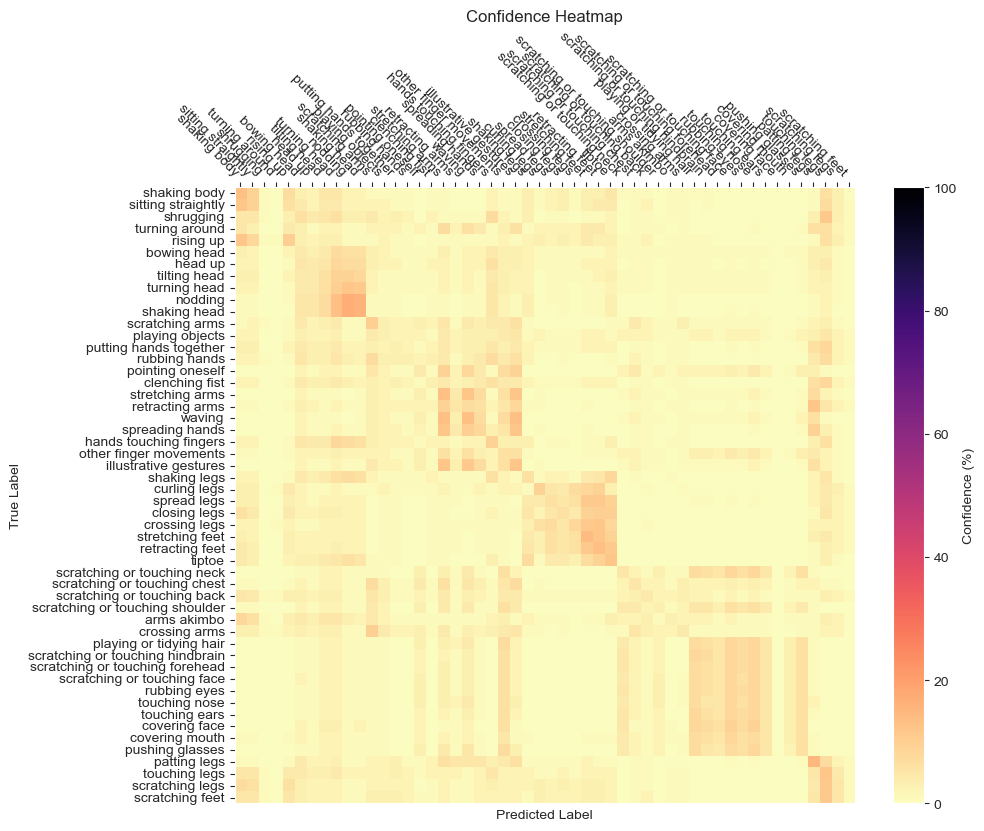

In [129]:
y_true_df = df[gt_columns].values
# y_true_df = y_true_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_true_df.columns})
y_pred_df = df[logit_columns].values
# y_pred_df = y_pred_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_pred_df.columns})
remove_features = ['head','hands','body','legs']
plot_confidence_heatmap(y_true_df, y_pred_df, feature_names, remove_features, annot=False)

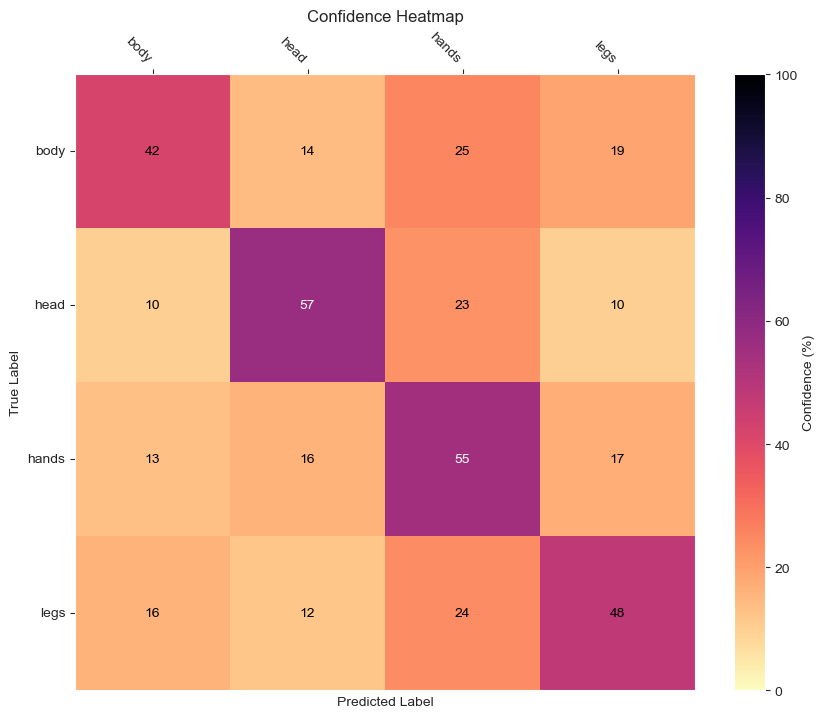

In [131]:
y_true_df = df[gt_columns].values
# y_true_df = y_true_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_true_df.columns})
y_pred_df = df[logit_columns].values
# y_pred_df = y_pred_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_pred_df.columns})
remove_features = list(set(feature_names) - set(['head','hands','body','legs']))
plot_confidence_heatmap(y_true_df, y_pred_df, feature_names, remove_features, annot=True)

In [134]:
df.columns

Index(['logit-shaking body', 'logit-sitting straightly', 'logit-shrugging',
       'logit-turning around', 'logit-rising up', 'logit-bowing head',
       'logit-head up', 'logit-tilting head', 'logit-turning head',
       'logit-nodding',
       ...
       'gt-touching legs', 'gt-scratching legs', 'gt-scratching feet',
       'gt-body', 'gt-head', 'gt-hands', 'gt-legs', 'side', 'camera_name',
       'view'],
      dtype='object', length=171)